#### Imports

In [1]:
import numpy as np
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

%matplotlib widget

#### Load data

In [6]:
# Load the .npz file
# data = np.load('../data/frustration_index/features_n6_x0_z0.npz') # 0, 0
# data = np.load('../data/frustration_index/features_n6_x0.01_z0.01.npz') # 0.01, 0.01
# data = np.load('../data/frustration_index/features_n6_x0.1_z0.1.npz') # 0.1, 0.1
# data = np.load('../data/frustration_index/features_n6_x1.0_z1.0.npz') # 1.0, 1.0
# data = np.load('../data/frustration_index/features_n6_x0_z0.1.npz') # 0, 0.1
# data = np.load('../data/frustration_index/features_n6_x0.1_z0.npz') # 0.1, 0
data = np.load('../data/frustration_index/features_n7_x0_z0.npz') # n7 0, 0

# Access the arrays
frustr_series = data['frustr_series']
mean_series = data['mean_series']
variance_series = data['variance_series']
skewness_series = data['skewness_series']
kurtosis_series = data['kurtosis_series']
fifth_mom_series = data['fifth_mom_series']
sixth_mom_series = data['sixth_mom_series']
pos_ratio_series = data['pos_ratio_series']

# Print the arrays to verify
print('frustr_series:', len(frustr_series))
print('skewness_series:', len(skewness_series))

# Remove elements of specific class/classes
for i in [5]:
    idx_to_remove = np.where(frustr_series == i)
    print('idx_to_remove:', idx_to_remove)
    frustr_series = np.delete(frustr_series, idx_to_remove)
    mean_series = np.delete(mean_series, idx_to_remove)
    variance_series = np.delete(variance_series, idx_to_remove)
    skewness_series = np.delete(skewness_series, idx_to_remove)
    kurtosis_series = np.delete(kurtosis_series, idx_to_remove)
    fifth_mom_series = np.delete(fifth_mom_series, idx_to_remove)
    sixth_mom_series = np.delete(sixth_mom_series, idx_to_remove)

# # Limit to classify between frustrated / non-frustrated
# for i in [2, 3, 4]:
#     idx_to_change = np.where(frustr_series == i)
#     print('idx_to_change:', idx_to_change)
#     frustr_series[idx_to_change] = 1

for i in range(len(skewness_series)):
    if np.isnan(skewness_series[i]):
        mean_series[i] = 0
        variance_series[i] = 0
        skewness_series[i] = 0
        frustr_series[i] = 0
        kurtosis_series[i] = 0
        fifth_mom_series[i] = 0
        sixth_mom_series[i] = 0

print('classes:', np.unique(frustr_series))
print('elements per class:', np.bincount(frustr_series))

print('frustr_series:', len(frustr_series))
print('mean_series:', len(mean_series))
print('variance_series:', len(variance_series))
print('skewness_series:', len(skewness_series))
print('kurtosis_series:', len(kurtosis_series))

frustr_series: 1000
skewness_series: 1000
idx_to_remove: (array([745]),)
classes: [0 1 2 3 4]
elements per class: [104 372 354 147  22]
frustr_series: 999
mean_series: 999
variance_series: 999
skewness_series: 999
kurtosis_series: 999


#### Run multinomial model

>0.0000 0.843 (0.015)
>0.0010 0.372 (0.000)
>0.0100 0.549 (0.017)
>0.0250 0.578 (0.016)
>0.0500 0.583 (0.014)
>0.0750 0.584 (0.015)
>0.1000 0.586 (0.014)
>0.1500 0.589 (0.015)
>0.2000 0.595 (0.014)
>0.5000 0.634 (0.018)
>1.0000 0.667 (0.018)
>0.0000: 0.860
>0.0010: 0.350
>0.0100: 0.523
>0.0250: 0.570
>0.0500: 0.587
>0.0750: 0.587
>0.1000: 0.587
>0.1500: 0.597
>0.2000: 0.603
>0.5000: 0.643
>1.0000: 0.683


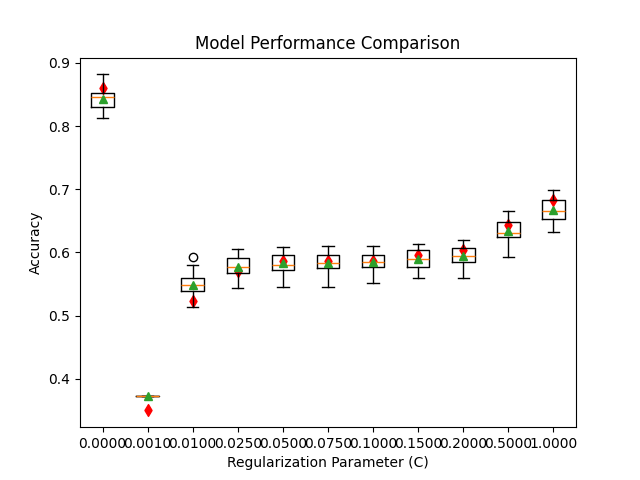

In [7]:
# max iteration
max_iters = 10000

# random n class classification dataset
# def get_dataset():
# 	X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1, n_classes=3)
# 	return X, y

# split the dataset by taking a random subset and return the training and test sets
# def split_train_test(X, y, test_size=0.3):
# 	n = len(X)
# 	n_test = int(n * test_size)
# 	n_train = n - n_test
# 	idx = np.random.permutation(n)
# 	X_train = X[idx[:n_train]]
# 	y_train = y[idx[:n_train]]
# 	X_test = X[idx[n_train:]]
# 	y_test = y[idx[n_train:]]
# 	return X_train, X_test, y_train, y_test

# get a list of models to evaluate
def get_models():
	models = dict()
	for p in [0.0, 0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.5, 1.0]:
		key = '%.4f' % p # string formatting
		if p == 0.0:
			models[key] = LogisticRegression(solver='lbfgs', max_iter=max_iters, penalty=None)
		else:
			models[key] = LogisticRegression(solver='lbfgs', max_iter=max_iters, penalty='l2', C=p)
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=20, random_state=49)
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
# X, y = get_dataset()
# X, y = np.random.rand(1000).reshape(-1, 1), frustr_series
# X, y = np.column_stack((np.random.rand(1000), np.random.rand(1000))), frustr_series
# X, y = variance_series.reshape(-1, 1), frustr_series
# X, y = skewness_series.reshape(-1, 1), frustr_series
# X, y = np.column_stack((variance_series, skewness_series)), frustr_series
# X, y = np.column_stack((variance_series, skewness_series, kurtosis_series)), frustr_series
X, y = np.column_stack((variance_series, skewness_series, kurtosis_series, fifth_mom_series, sixth_mom_series)), frustr_series

# split 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
	
# test the models and store the results
results_acc = list()
for name, model in models.items():
	model.fit(X_train, y_train)
	y_hat = model.predict(X_test)
	acc = np.mean(y_hat == y_test)
	results_acc.append(acc)
	print('>%s: %.3f' % (name, acc))

# plot model performance for comparison

pyplot.figure()
pyplot.boxplot(results, showmeans=True) # mean: green triangle, median: orange line, 1st and 3rd quartiles: box
pyplot.scatter([i for i in range(1, 12)], results_acc, color='red', marker='d')
pyplot.xticks([i for i in range(1, 12)], names)
pyplot.xlabel('Regularization Parameter (C)')
pyplot.ylabel('Accuracy')
pyplot.title('Model Performance Comparison')
pyplot.show()

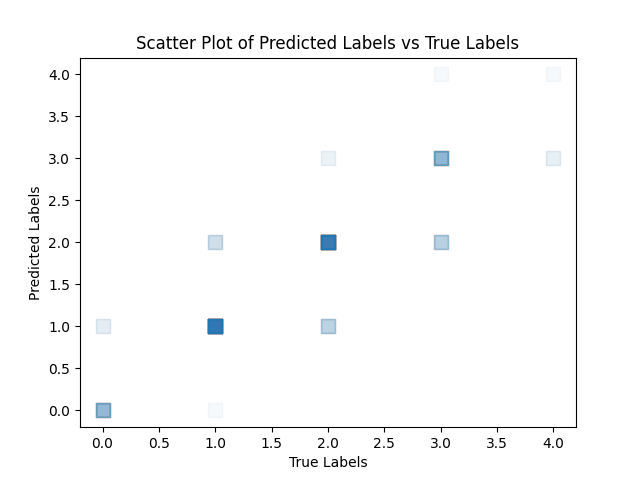

In [8]:
from sklearn.model_selection import train_test_split

# Define dataset
# X, y = skewness_series.reshape(-1, 1), frustr_series

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

# Get the model to evaluate
model = LogisticRegression(solver='lbfgs', max_iter=max_iters, penalty=None)
# model = LogisticRegression(solver='lbfgs', penalty='l2', C=1)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Plot scatter plot of predicted labels vs true labels
pyplot.figure()
pyplot.scatter(y_test, y_pred, marker='s', alpha=0.02, color='C0', s=100)
pyplot.xlabel('True Labels')
pyplot.ylabel('Predicted Labels')
pyplot.title('Scatter Plot of Predicted Labels vs True Labels')
pyplot.show()

#### PCA

[Text(0.5, 0, 'Component 1'), Text(0, 0.5, 'Component 2')]

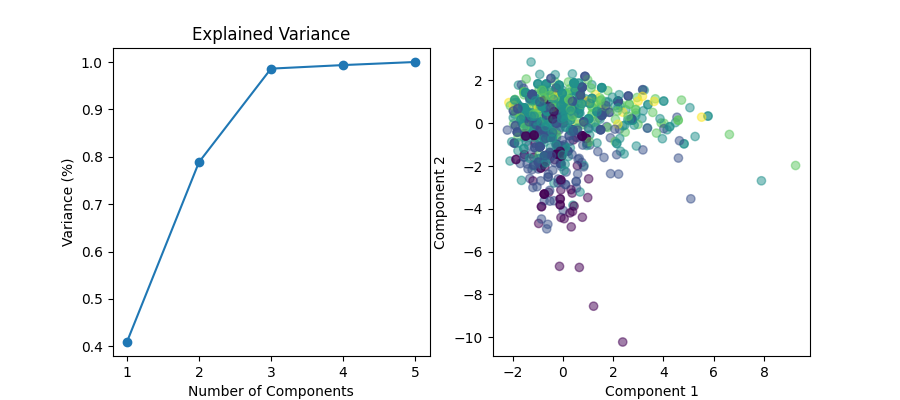

In [9]:
# Features and labels
X, y = np.column_stack((variance_series, skewness_series, kurtosis_series, fifth_mom_series, sixth_mom_series)), frustr_series

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Features and labels
X, y = np.column_stack((variance_series, skewness_series, kurtosis_series, fifth_mom_series, sixth_mom_series)), frustr_series

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply reduction
dim_reduction = PCA()  # You can change the number of components
X_dr = dim_reduction.fit_transform(X_scaled)

# Plot
fig, axs = pyplot.subplots(1, 2, figsize=(9, 4))
pca = PCA().fit(X_scaled)
axs[0].plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
axs[0].scatter(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
axs[0].set(xlabel='Number of Components', ylabel='Variance (%)', title='Explained Variance')
axs[1].scatter(X_dr[:, 0], X_dr[:, 1], c=y, cmap='viridis', alpha=0.5)
axs[1].set(xlabel='Component 1', ylabel='Component 2')


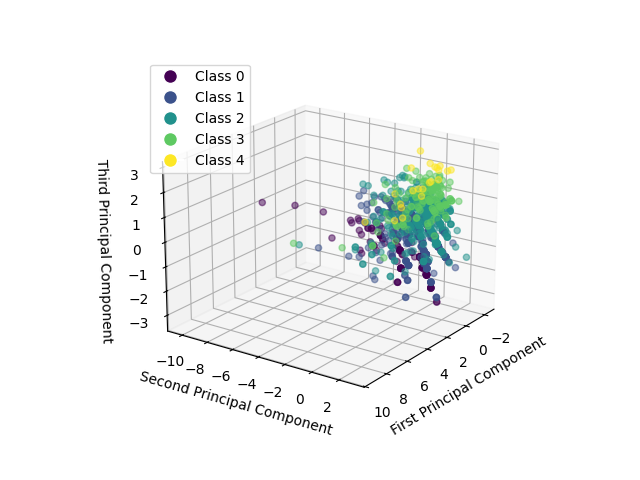

In [10]:
# Plot 3D

%matplotlib widget

import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

fig = pyplot.figure()

ax = fig.add_subplot(111, projection='3d', elev=20, azim=35)
scatter = ax.scatter(X_dr[:, 0], X_dr[:, 1], X_dr[:, 2], c=y, alpha=0.5)
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')

# Create custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Class {i}',
                          markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10)
                   for i in set(y)]
ax.legend(handles=legend_elements)

#### t-SNE

[Text(0.5, 0, 'Component 1'), Text(0, 0.5, 'Component 2')]

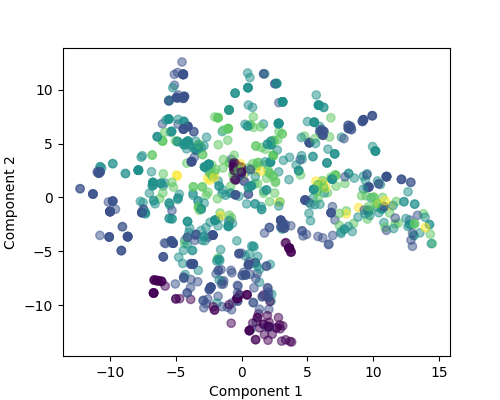

In [11]:
# Features and labels
X, y = np.column_stack((variance_series, skewness_series, kurtosis_series, fifth_mom_series, sixth_mom_series)), frustr_series

import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Features and labels
X, y = np.column_stack((variance_series, skewness_series, kurtosis_series, fifth_mom_series, sixth_mom_series)), frustr_series

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply reduction
dim_reduction = TSNE(n_components=3, random_state=111)
X_dr = dim_reduction.fit_transform(X_scaled)

# Plot
fig, axs = pyplot.subplots(1, 1, figsize=(5, 4))
axs.scatter(X_dr[:, 0], X_dr[:, 1], c=y, cmap='viridis', alpha=0.5)
axs.set(xlabel='Component 1', ylabel='Component 2')

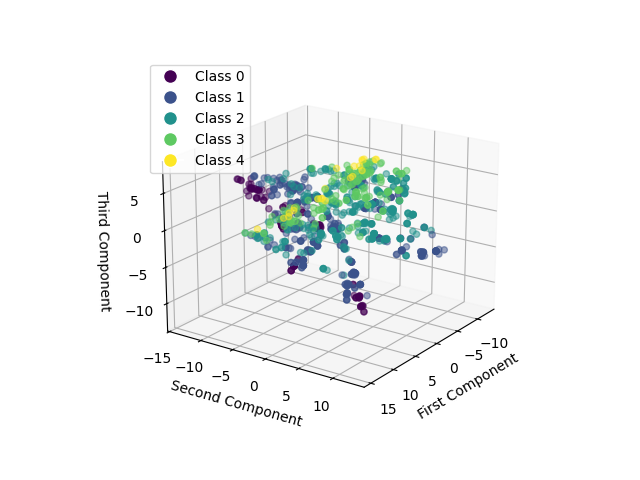

In [12]:

# Plot 3D

%matplotlib widget

import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

fig = pyplot.figure()

ax = fig.add_subplot(111, projection='3d', elev=20, azim=35)
scatter = ax.scatter(X_dr[:, 0], X_dr[:, 1], X_dr[:, 2], c=y, alpha=0.5)
ax.set_xlabel('First Component')
ax.set_ylabel('Second Component')
ax.set_zlabel('Third Component')

# Create custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Class {i}',
                          markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10)
                   for i in set(y)]
ax.legend(handles=legend_elements)